Reproduce Chaplin 2010

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import kplr
import numpy as np
import sys
sys.path.insert(0, '../')

In [2]:
def light_curve(kic): 
    client = kplr.API()

    # Find the target KOI.
    koi = client.star(kic)

    # Get a list of light curve datasets.
    lcs = koi.get_light_curves(short_cadence=True)

    # Loop over the datasets and read in the data.
    time, flux = [], []
    for lc in lcs:
        with lc.open() as f:
            # The lightcurve data are in the first FITS HDU.
            hdu_data = f[1].data
            t = hdu_data["time"]
            f = hdu_data["sap_flux"]
            not_nan = ~np.isnan(f) & ~np.isnan(t)
            fit = np.polyval(np.polyfit(t[not_nan] - t[not_nan].mean(), f[not_nan], 5), 
                             t[not_nan] - t[not_nan].mean())
            time.append(t[not_nan])
            flux.append(f[not_nan]/fit)

    time = np.concatenate(time)
    flux = np.concatenate(flux)
    short_cadence = np.logical_not(np.diff(time) > 1/60/24)
    time = time[1:][short_cadence]
    flux = flux[1:][short_cadence]
    
    return time, flux

In [3]:
time, flux = light_curve(6116048)

In [4]:
gaps = np.diff(time) > 50000*np.median(np.diff(time))

In [5]:
from astropy.stats import sigma_clipping, mad_std
from shocksgo import interpolate_missing_data

/Users/bmmorris/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


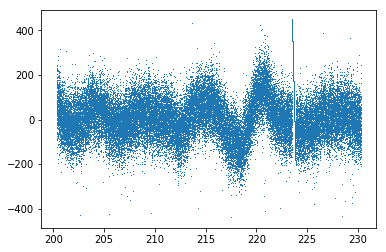

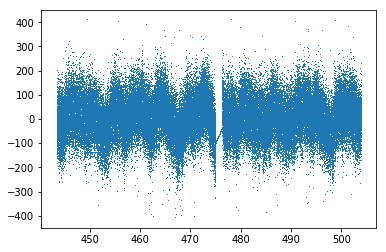

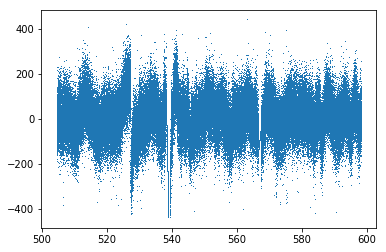

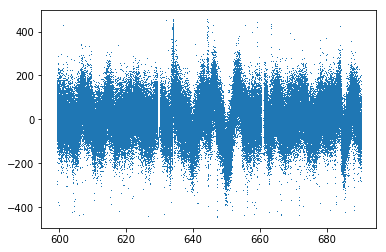

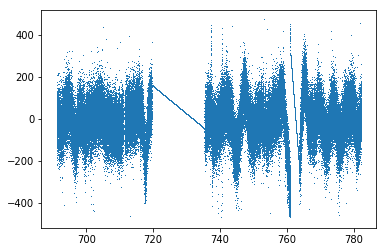

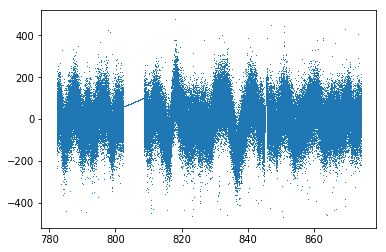

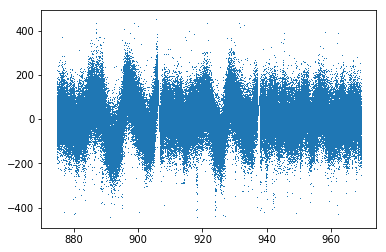

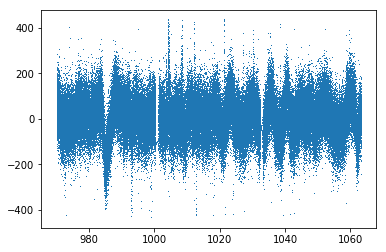

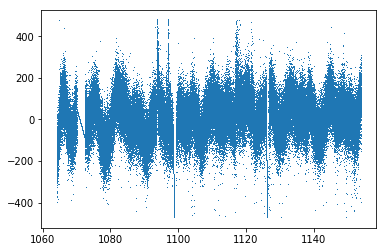

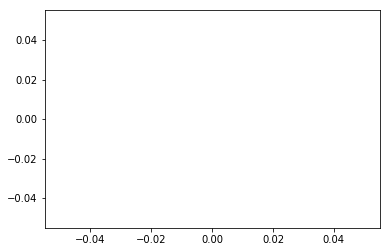

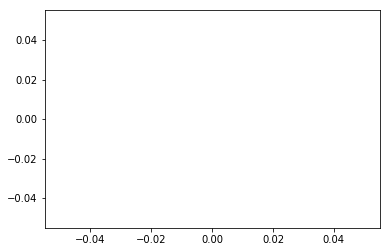

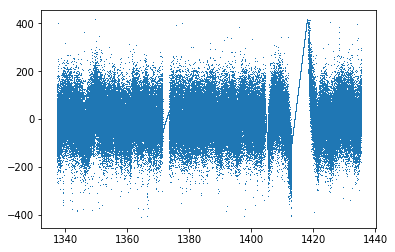

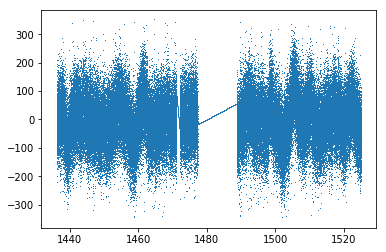

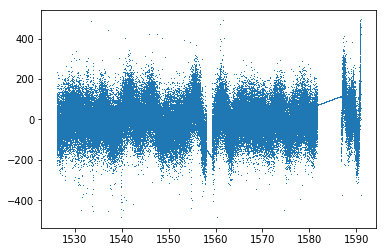

In [6]:
gap_inds = np.concatenate([[0], np.ix_(gaps)[0], [len(time)]])

chunks = []
for i in range(len(gap_inds) - 1):
    t, f = time[gap_inds[i]+1:gap_inds[i+1]], flux[gap_inds[i]+1:gap_inds[i+1]]
    t, f = interpolate_missing_data(t, f)
    f = sigma_clipping.sigma_clip(f, sigma=5, stdfunc=mad_std)
    
    if t.ptp() > 5: 
        #t, f = interpolate_missing_data(t, f)
        chunks.append([t, (f-np.nanmedian(f))])
        plt.plot(t, 1e6*(f-np.nanmedian(f)), ',')
        plt.show()

In [7]:
times = np.concatenate([chunk[0][~chunk[1].mask] for chunk in chunks])
fluxes = np.concatenate([chunk[1][~chunk[1].mask] for chunk in chunks])

times, fluxes = interpolate_missing_data(times[np.argsort(times)], fluxes[np.argsort(times)])

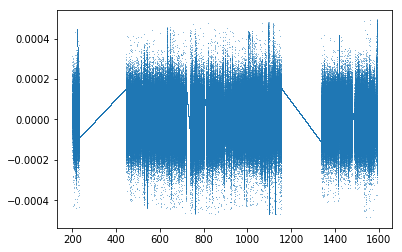

In [8]:
plt.plot(times, fluxes, ',', alpha=0.5)

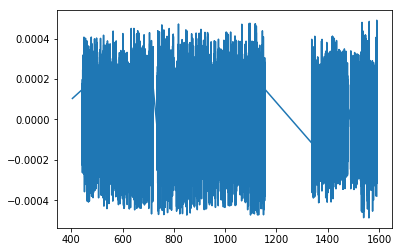

In [9]:
plt.plot(times[300000:], fluxes[300000:])

In [12]:
from shocksgo import power_spectrum
freqs, powers = power_spectrum(fluxes[300000:], d=60)
freqs *= 1e6

In [13]:
from scipy.stats import binned_statistic

cutoff_freq = 1e5
bs = binned_statistic(np.log(freqs[freqs != 0]), powers[freqs != 0], statistic=np.nanmedian, bins=10000)
bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])
binned_power = bs.statistic[np.exp(bincenters) < cutoff_freq]
binned_freq = np.exp(bincenters)[np.exp(bincenters) < cutoff_freq]

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


(1e-10, 1e-06)

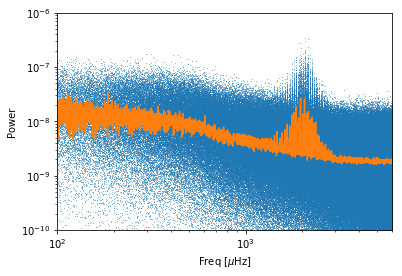

In [14]:
plt.loglog(freqs, powers, ',', alpha=0.5)
plt.loglog(binned_freq, binned_power)
plt.xlabel('Freq [$\mu$Hz]')
plt.ylabel('Power')
plt.xlim([1e2, 6e3])
plt.ylim([1e-10, 1e-6])

(1e-10, 1e-06)

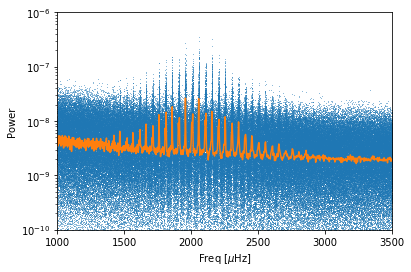

In [15]:
from scipy.ndimage import gaussian_filter1d

plt.semilogy(freqs, powers, ',', alpha=0.5)
# plt.semilogy(freqs[np.argsort(freqs)], gaussian_filter1d(powers[np.argsort(freqs)], 100))
plt.semilogy(binned_freq, binned_power)

plt.xlabel('Freq [$\mu$Hz]')
plt.ylabel('Power')
plt.xlim([1000, 3500])
plt.ylim([1e-10, 1e-6])

In [16]:
import sys
sys.path.insert(0, '../')

from shocksgo import generate_stellar_fluxes

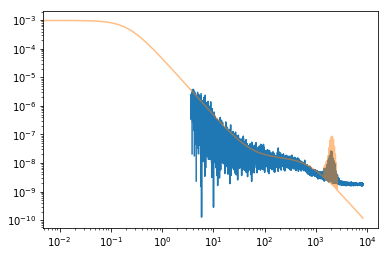

In [17]:
from astropy.constants import M_sun, L_sun, R_sun
import astropy.units as u


# KIC 6116048
M = 1.12 * M_sun #  (Mathur+, 2012) 
T_eff = 5980 * u.K # Gaia DR2  
L = 1.851 * L_sun # Gaia DR2
R = 1.27 * R_sun # Gaia DR2
times, fluxes, kernel = generate_stellar_fluxes(duration=10*u.min, M=M, T_eff=T_eff, L=L, R=R)

plt.semilogy(binned_freq, binned_power)

plt.loglog(freqs, kernel.get_psd(2*np.pi*freqs*1e-6)/2/np.pi, alpha=0.5)

(1e-10, 1e-06)

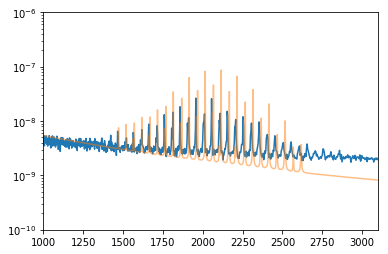

In [18]:
plt.semilogy(binned_freq, binned_power)

plt.semilogy(freqs, kernel.get_psd(2*np.pi*freqs*1e-6)/2/np.pi, alpha=0.5)
plt.xlim([1000, 3100])
plt.ylim([1e-10, 1e-6])

/Users/bmmorris/anaconda/lib/python3.5/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


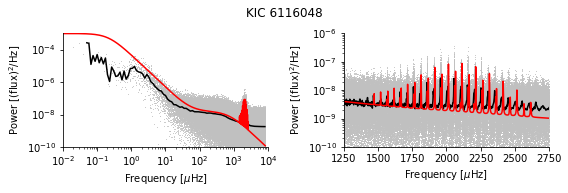

In [21]:
psd = kernel.get_psd(2*np.pi*freqs*1e-6) / 2 / np.pi

left_bs = binned_statistic(freqs, powers, statistic=np.nanmedian, 
                           bins=np.logspace(-2, 4, 100))
bincenters = 0.5 * (left_bs.bin_edges[1:] + left_bs.bin_edges[:-1])

fig, ax = plt.subplots(1, 2, figsize=(8, 2.5))
ax[0].loglog(freqs, powers, marker=',', lw=0, alpha=0.8, rasterized=True, color='silver')
ax[0].loglog(bincenters, left_bs.statistic, color='k')

ax[0].loglog(freqs, psd, color='r')
ax[0].set_xlim([1e-2, 1e4])
ax[0].set_ylim([1e-10, 1e-3])
ax[0].set_xlabel('Frequency [$\mu$Hz]')
ax[0].set_ylabel('Power [(flux)$^2$/Hz]')

ax[1].semilogy(freqs, powers, marker=',', lw=0, alpha=0.8, rasterized=True, color='silver')
ax[1].semilogy(binned_freq, binned_power, color='k')
ax[1].semilogy(freqs, psd, color='r')
ax[1].set_xlim([1250, 2750])
ax[1].set_ylim([1e-10, 1e-6])
ax[1].set_xlabel('Frequency [$\mu$Hz]')
ax[1].set_ylabel('Power [(flux)$^2$/Hz]')

for s in ['right', 'top']:
    for axis in ax: 
        axis.spines[s].set_visible(False)

fig.tight_layout()

fig.suptitle('KIC 6116048', va='bottom')

fig.savefig('paper_plots/kic611.pdf', bbox_inches='tight', dpi=300)

In [20]:
near_peak = (binned_freq < 4000) & (binned_freq > 2500)
observed_nu_max = binned_freq[near_peak][np.argmax(binned_power[near_peak])]

near_peak = (freqs < 4000) & (freqs > 2500)
simulated_nu_max = freqs[near_peak][np.argmax(psd[near_peak])]
print(observed_nu_max, simulated_nu_max)

np.save("validation_peaks/6116048.npy", [observed_nu_max, simulated_nu_max])

2554.489922804266 2515.754500554634
